# Simulated Results
The below plot shows the containment index distribution for simulated reads (a function of how contained a read is with positive values meaning truly contained).  The reads are simulated to 30x coverage with the Oxford Nanopore MinION read length distribution (using public Arabidopsis data) from a section of 5 Mbp of the human genome.  

In [1]:
import matplotlib.pyplot as plt

scorefn = '/home/mkirsche/github/ContainedReadRemoval/sim/simulatedscores.txt'

buckets = [1000 * i for i in range(-40, 40)]

containmentIndex = []
names = []
lens = []

numContained, numUncontained = 0, 0
sumContained, sumUncontained = 0, 0

nameToScore = dict()
nameToIndex = dict()

with open(scorefn) as f:
    index = 0
    for line in f:
        tokens = line.split()
        curScore = int(tokens[1])
        curLen = int(tokens[3])-int(tokens[2])
        lens.append(curLen)
        containmentIndex.append(curScore)
        names.append(tokens[0])
        nameToScore[tokens[0]] = curScore
        nameToIndex[tokens[0]] = index
        if curScore >= 0:
            numContained += 1
            sumContained += curLen
        else:
            numUncontained += 1
            sumUncontained += curLen
        index += 1
        
totLength = sumContained + sumUncontained
                  
print('Number of contained reads: ' + str(numContained))
print('Number of uncontained reads: ' + str(numUncontained))
print('Total length of contained reads: ' + str(sumContained))
print('Total length of uncontained reads: ' + str(sumUncontained))
print('Perecent of total length uncontained: ' + str(float(sumUncontained * 100) / float(totLength)))

plt.hist(containmentIndex, bins = buckets, color = 'mediumaquamarine')
plt.title('Containment Index')
plt.show()

Number of contained reads: 17144
Number of uncontained reads: 601
Total length of contained reads: 127124725
Total length of uncontained reads: 22891993
Perecent of total length uncontained: 15.259627930268412


<Figure size 640x480 with 1 Axes>

## How well the filter does
Here is the same plot, but with reads colored based on whether or not my filter removed them.  Note the sharp decline in proportion kept as the y-axis is crossed and it goes from uncontained reads to contained reads. 

I use the following parameters:

k = 15, w = 11 for minimizers

Filter all reads < 12 kbp automatically

Threshold for chain length chosen so approximately 8% of short reads kept as uncontained

Number called uncontained: 1756
Proportion of uncontained reads that were kept: 580 out of 601(recall: 0.9650582362728786)
Proportion of kept reads which are uncontained: 580 out of 1756(precision: 0.33029612756264237)
Percent of bases kept: 32.68170351520422
Percent of reads kept: 9.895745280360664
Lowest containment indices of removed reads:
[-3402, -3061, -2963, -2655, -2156, -1946, -1900, -1451, -1216, -935, -915, -866, -703, -660, -571, -561, -496, -415, -359, -135, -3, 14, 241, 318, 351, 377, 437, 449, 462, 479]


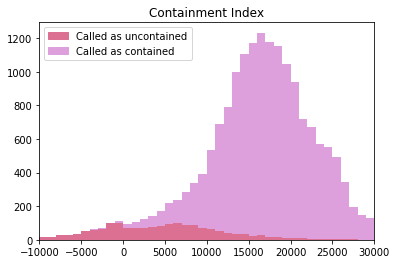

In [2]:
import matplotlib.patches as mpatches

uncontainedCI = []
containedCI = []

myUncontainedLen = 0

resultsfn = '/home/mkirsche/eclipse-workspace/PacBioHashing/uncontainedreadnames.txt'

uncontainedNames = set()

with open(resultsfn) as f:
    for line in f:
        uncontainedNames.add(line.split()[0])
        
print('Number called uncontained: ' + str(len(uncontainedNames)))

tp = 0

for a in nameToScore:
    b = nameToScore[a]
    if a in uncontainedNames:
        uncontainedCI.append(b)
        myUncontainedLen += lens[nameToIndex[a]]
        if b < 0:
            tp += 1
    else:
        containedCI.append(b)
        
recall = float(tp) / float(numUncontained)
precision = float(tp) / float(len(uncontainedNames))
        
print('Proportion of uncontained reads that were kept: ' + str(tp) + ' out of ' + str(numUncontained) + '(recall: ' + str(recall) + ')')
print('Proportion of kept reads which are uncontained: ' + str(tp) + ' out of ' + str(len(uncontainedNames)) + '(precision: ' + str(precision) + ')')


print('Percent of bases kept: '+ str(float(myUncontainedLen * 100) / float(totLength)))
print('Percent of reads kept: '+ str(float(len(uncontainedCI) * 100) / float(numContained + numUncontained)))

colors = ['palevioletred', 'plum']

containedCI.sort()
print('Lowest containment indices of removed reads:')
print(containedCI[0:30])

uncontainedCI.sort()
        
plt.hist([uncontainedCI, containedCI], color = colors , bins = buckets, stacked = True)

labels = ['Called as uncontained', 'Called as contained']
legendHandles = []
for i in range(0, len(colors)):
    legendHandles.append(mpatches.Patch(color=colors[i], label=labels[i]))
plt.legend(handles=legendHandles)
plt.title('Containment Index')
plt.xlim(-10000, 30000)

plt.show()

## Number of false positives and negatives:

In [3]:
wronglyRemovedNames = set()
wronglyKeptNames = set()

for name in nameToScore:
    score = nameToScore[name]
    if score < 0 and name not in uncontainedNames:
        wronglyRemovedNames.add(name)
    if score >= 0 and name in uncontainedNames:
        wronglyKeptNames.add(name)
        
print('Wrongly removed count: ' + str(len(wronglyRemovedNames)))
print('Wrongly kept count: ' + str(len(wronglyKeptNames)))

Wrongly removed count: 21
Wrongly kept count: 1176


## Looking at the chains of minimizer matches within the more extreme wrong guesses

In [4]:
nameToLog = dict()
logfile = '/home/mkirsche/eclipse-workspace/PacBioHashing/log.txt'
with open(logfile) as f:
    for line in f:
        tokens = line.split('\t')
        curName = tokens[0].split()[0]
        nameToLog[curName] = tokens

In [5]:
print('Wrongly discarded read which are most uncontained')
for name in wronglyRemovedNames:
    if name in nameToLog and nameToScore[name] < 0 and nameToScore[name] < containedCI[5]:
        tokens = nameToLog[name]
        longestChain = int(tokens[1])
        numMinimizers = int(tokens[5])
        readLength = int(tokens[3])
        chain = tokens[2]
        ci = nameToScore[name]
        print(name + ' ' + str(longestChain) + ' ' + str(numMinimizers) + ' ' + str(readLength) + ' ' + str(ci) + ' ' + chain)
        print('')

Wrongly discarded read which are most uncontained
read14057 122 6493 35964 -3402 [86, 420, 714, 716, 718, 1888, 2405, 4598, 4708, 4989, 5446, 5447, 5452, 5782, 6028, 6966, 7014, 7096, 7106, 7107, 7115, 7122, 7123, 7368, 9402, 9749, 9994, 10061, 10378, 10381, 11310, 11312, 11313, 11448, 11459, 11462, 11470, 11566, 11632, 11643, 11645, 11652, 11844, 11908, 12357, 12383, 12449, 12450, 12761, 13093, 13577, 14102, 14744, 14922, 15096, 15321, 15452, 15627, 15983, 16267, 16526, 16527, 16920, 17077, 17315, 17526, 17537, 17538, 18380, 18446, 19073, 19074, 19636, 20180, 20645, 20648, 20794, 20948, 20949, 20998, 21147, 22124, 23900, 24095, 24604, 25622, 25623, 25936, 26339, 26461, 26890, 26898, 26901, 27213, 27249, 27588, 27639, 28549, 28660, 28965, 29225, 29410, 29415, 29807, 30958, 30959, 31028, 32120, 32128, 33400, 33403, 33404, 33875, 33882, 33883, 34584, 34850, 34957, 35185, 35186, 35603, 35607]

read7638 92 5343 29891 -2963 [53, 351, 788, 870, 1080, 1272, 1311, 2183, 2186, 2667, 2674, 2675,

In [8]:
print('Wrongly kept reads which are most contained')
for name in wronglyKeptNames:
    if name in nameToLog and nameToScore[name] > 0 and nameToScore[name] > uncontainedCI[len(uncontainedCI)-5]:
        tokens = nameToLog[name]
        longestChain = int(tokens[1])
        numMinimizers = int(tokens[5])
        readLength = int(tokens[3])
        chain = tokens[2]
        ci = nameToScore[name]
        print(name + ' ' + str(longestChain) + ' ' + str(numMinimizers) + ' ' + str(readLength) + ' ' + str(ci) + ' ' + chain)
        print('')

Wrongly kept reads which are most contained
read2964 50 2463 13624 12240 [890, 1431, 1627, 1635, 2323, 2345, 2372, 3216, 3565, 3817, 3844, 5050, 5057, 5198, 5462, 5665, 6373, 6890, 6892, 6893, 7168, 7172, 7414, 7456, 7457, 7662, 7734, 7737, 7871, 9115, 9116, 9328, 10341, 10346, 10440, 10444, 10565, 10569, 10701, 10707, 11011, 11295, 11301, 11377, 11378, 11882, 12286, 12289, 13183, 13337]

read13665 70 4174 23146 12293 [4681, 5130, 5440, 5448, 6160, 6164, 6169, 6222, 6819, 6825, 6827, 6828, 6976, 7138, 7344, 7621, 8238, 8404, 9378, 9510, 9905, 9907, 10386, 11434, 11443, 11449, 11492, 11500, 11503, 11954, 11959, 12183, 12238, 12464, 14654, 15267, 15271, 15275, 15578, 15816, 15905, 16319, 16935, 16936, 17040, 17480, 18126, 18254, 18255, 18265, 18348, 18460, 18540, 18787, 18900, 18907, 19011, 19013, 19023, 19728, 20304, 20835, 20845, 21105, 21113, 21135, 21184, 21340, 22540, 23124]

read13409 95 4373 24164 26748 [463, 1649, 2246, 2319, 2450, 2456, 2514, 2591, 3098, 3139, 3503, 3650, 3915, 

## How the number of incorrectly removed reads compares to a length-based threshold
Here the length threshold is set to match the number of removed reads of the filter settings.  Note that even with the same number of reads, the length-based filter keeps 5% more of the overall bases because it throws out mostly shorter reads.  Even so, my filter is outperforming the length-based filter in terms of the number of incorrectly removed reads.

In [7]:
def countLen(countKeep, lens, ct):
    sorter = []
    for i in range(0, len(lens)):
        sorter.append((lens[i], ct[i]))
    sorter.sort()
    bad = 0
    totRemovedLen = 0
    lt = str(sorter[len(lens)-countKeep][0])
    print('Length threshold to remove same number of reads: ' + str(lt))
    for i in range(0, len(lens)-countKeep-1):
        totRemovedLen += sorter[i][0]
        if sorter[i][1] < 0:
            bad += 1
    print('Length-based incorrectly removed: ' + str(bad))
    percentBasesRemoved = 100*float(totLength - totRemovedLen) / float(totLength)
    print('Length-based percent of bases kept ' + str(percentBasesRemoved))
   
print('My incorrectly removed: ' + str(len(wronglyRemovedNames)))
countLen(len(uncontainedNames), lens, containmentIndex)

print('My percent of bases kept: '+ str(float(myUncontainedLen * 100) / float(totLength)))

My incorrectly removed: 21
Length threshold to remove same number of reads: 23267
Length-based incorrectly removed: 35
Length-based percent of bases kept 37.96743240310057
My percent of bases kept: 32.68170351520422
